In [1]:

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

import seaborn as sns
sns.set_context("paper", font_scale=0.7)
sns.set_style("white")
import os

%load_ext autoreload
%autoreload 2


In [100]:
import performance
import gc

redis_hostname = '192.168.1.101'
redis_password = 'FILL IN HERE'

all_results_fn = 'performance_results.parquet'
if os.path.exists(all_results_fn):
    all_results = pd.read_parquet(all_results_fn)
else:
    all_results = []
    for d in [
            dict(
                # Event latency: many quick events: what's the latency?
                dt=0.001,
                batch_size=1,
                n_samples=int(round(1 / 0.001 * 10)),
                sample_size_bytes=sample_size_bytes,
                num_readers=num_readers,
                tag='event',
            ) for sample_size_bytes in (8, 16, 32, 64, 128) for num_readers in (1, 2, 4, 8, 16, 32)
        ] + [
            dict(
                dt=dt,
                batch_size=int(round(32 * 1000 * dt)),  # => every 1ms, send 32 samples: ==> 32 kHz
                n_samples=32000 * 20,
                # Simulate "384" channels of 2-bytes per sample
                sample_size_bytes=384 * 2,
                num_readers=1,
                tag='ephys',
            ) for dt in (0.001, 0.002, 0.004, 0.008, 0.016, 0.032)
        ] + [
            dict(
                dt=1 / 120.0,  # Simulate 120Hz
                batch_size=1,
                n_samples=120 * 20,
                # Imaging: 120 Hz data, with big payloads
                sample_size_bytes=sample_size_bytes,
                num_readers=1,
                tag='imaging',
            ) for sample_size_bytes in (640 * 480, 320 * 240, 1280 * 960)
    ]:
        tag = d.pop('tag')
        df = performance.test_performance(
            redis_hostname=redis_hostname,
            redis_password=redis_password,
            redis_port=6379,
            **d,
        )
        dt = d['dt']

        fig, ax = plt.subplots(figsize=(10, 5))
        sns.histplot(
            data=df,
            x='latency_ms',
            ax=ax
        )

        print(pd.Series(df['latency_ms']).describe())
        from scipy import stats
        latency_ms = df['latency_ms'].to_numpy()
        for f in (95.0, 99.0, 99.9):
            print(f'{f:.1f}%ile\t{np.percentile(latency_ms, f):.4f}')
        print(f'%ile of {dt * 1e3:.1f}ms', stats.percentileofscore(df['latency_ms'], dt * 1e3))
        all_results.append(df.assign(tag=tag))
        gc.collect()

    all_results = pd.concat(all_results)
all_results


,sample_written_at,sample_index,sample_received_at,latency,latency_ms,dt,batch_size,n_samples,sample_size_bytes,num_readers,tag
0,1.265738e+07,100,1.265738e+07,0.000424,0.424232,0.001000,1,10000,8,1,event
1,1.265738e+07,101,1.265738e+07,0.000258,0.258027,0.001000,1,10000,8,1,event
2,1.265738e+07,102,1.265738e+07,0.000192,0.192445,0.001000,1,10000,8,1,event
3,1.265738e+07,103,1.265738e+07,0.000200,0.199534,0.001000,1,10000,8,1,event
4,1.265738e+07,104,1.265738e+07,0.000145,0.145277,0.001000,1,10000,8,1,event
...,...,...,...,...,...,...,...,...,...,...,...
346570,1.266884e+07,2495,1.266884e+07,0.272183,272.183424,0.008333,1,2400,1228800,1,imaging
346571,1.266884e+07,2496,1.266884e+07,0.271037,271.036876,0.008333,1,2400,1228800,1,imaging
346572,1.266884e+07,2497,1.266884e+07,0.270373,270.372793,0.008333,1,2400,1228800,1,imaging
346573,1.266884e+07,2498,1.266884e+07,0.269819,269.819153,0.008333,1,2400,1228800,1,imaging


I20220627 09:37:46.047742 3539691 redis.cpp:47] AUTH response: OK
I20220627 09:37:46.058657 3539691 writer.cpp:231] Relative time (local - server) = -954 us
I20220627 09:37:46.058965 3539691 writer.cpp:90] Stream metadata:
I20220627 09:37:46.058972 3539691 writer.cpp:92] => user_metadata: null
I20220627 09:37:46.058976 3539691 writer.cpp:92] => local_minus_server_clock_us: -954
I20220627 09:37:46.058980 3539691 writer.cpp:92] => schema: {"field_definitions":[{"name":"data","size":32,"type":"FIXED_WIDTH_BYTES"}]}
I20220627 09:37:46.058984 3539691 writer.cpp:92] => initialized_at_us: 1656347866059621
I20220627 09:37:46.058990 3539691 writer.cpp:92] => first_stream_key: f279bcf4-a60f-429e-9add-2d97391429d9-0


Writing with batch size 1, # batches 32000 [total 32000]
Sleeping, waiting for everything to catch up...
Executing!


I20220627 09:37:50.934459 3539691 writer.cpp:246] Adding eof entry for stream f279bcf4-a60f-429e-9add-2d97391429d9, idx 0 at samples 32100
I20220627 09:37:51.303314 3558674 redis.cpp:47] AUTH response: OK
I20220627 09:37:55.169737 3558674 reader.cpp:199] EOF received! Ending stream with 0 elements at sample 32099
I20220627 09:37:55.242436 3539691 redis.cpp:47] AUTH response: OK
I20220627 09:37:55.253742 3539691 writer.cpp:231] Relative time (local - server) = -952 us
I20220627 09:37:55.254133 3539691 writer.cpp:90] Stream metadata:
I20220627 09:37:55.254141 3539691 writer.cpp:92] => user_metadata: null
I20220627 09:37:55.254146 3539691 writer.cpp:92] => local_minus_server_clock_us: -952
I20220627 09:37:55.254150 3539691 writer.cpp:92] => schema: {"field_definitions":[{"name":"data","size":32,"type":"FIXED_WIDTH_BYTES"}]}
I20220627 09:37:55.254154 3539691 writer.cpp:92] => initialized_at_us: 1656347875254707
I20220627 09:37:55.254158 3539691 writer.cpp:92] => first_stream_key: 976cadaf-

1
1
Writing with batch size 2, # batches 16000 [total 32000]
Sleeping, waiting for everything to catch up...
Executing!


I20220627 09:37:58.387344 3539691 writer.cpp:246] Adding eof entry for stream 976cadaf-d98c-471f-80ac-8f7049fed736, idx 0 at samples 32200
I20220627 09:37:58.754686 3558679 redis.cpp:47] AUTH response: OK
I20220627 09:38:00.905534 3558679 reader.cpp:199] EOF received! Ending stream with 0 elements at sample 32199
I20220627 09:38:00.969401 3539691 redis.cpp:47] AUTH response: OK
I20220627 09:38:00.980334 3539691 writer.cpp:231] Relative time (local - server) = -953 us
I20220627 09:38:00.980648 3539691 writer.cpp:90] Stream metadata:
I20220627 09:38:00.980655 3539691 writer.cpp:92] => user_metadata: null
I20220627 09:38:00.980660 3539691 writer.cpp:92] => local_minus_server_clock_us: -953
I20220627 09:38:00.980664 3539691 writer.cpp:92] => schema: {"field_definitions":[{"name":"data","size":32,"type":"FIXED_WIDTH_BYTES"}]}
I20220627 09:38:00.980669 3539691 writer.cpp:92] => initialized_at_us: 1656347880981297
I20220627 09:38:00.980672 3539691 writer.cpp:92] => first_stream_key: c7b85990-

1
1
Writing with batch size 4, # batches 8000 [total 32000]
Sleeping, waiting for everything to catch up...
Executing!


I20220627 09:38:03.248847 3539691 writer.cpp:246] Adding eof entry for stream c7b85990-ae7d-43d0-a490-260b94a5fd12, idx 0 at samples 32400
I20220627 09:38:03.616196 3558681 redis.cpp:47] AUTH response: OK
I20220627 09:38:04.892923 3558681 reader.cpp:199] EOF received! Ending stream with 0 elements at sample 32399
I20220627 09:38:04.952080 3539691 redis.cpp:47] AUTH response: OK
I20220627 09:38:04.962941 3539691 writer.cpp:231] Relative time (local - server) = -956 us
I20220627 09:38:04.963272 3539691 writer.cpp:90] Stream metadata:
I20220627 09:38:04.963279 3539691 writer.cpp:92] => user_metadata: null
I20220627 09:38:04.963284 3539691 writer.cpp:92] => local_minus_server_clock_us: -956
I20220627 09:38:04.963289 3539691 writer.cpp:92] => schema: {"field_definitions":[{"name":"data","size":32,"type":"FIXED_WIDTH_BYTES"}]}
I20220627 09:38:04.963292 3539691 writer.cpp:92] => initialized_at_us: 1656347884963908
I20220627 09:38:04.963296 3539691 writer.cpp:92] => first_stream_key: 14f73307-

1
1
Writing with batch size 8, # batches 4000 [total 32000]
Sleeping, waiting for everything to catch up...
Executing!


I20220627 09:38:06.805532 3539691 writer.cpp:246] Adding eof entry for stream 14f73307-9a24-4ecd-b1db-062317d27731, idx 0 at samples 32800
I20220627 09:38:07.175096 3558683 redis.cpp:47] AUTH response: OK
I20220627 09:38:08.057555 3558683 reader.cpp:199] EOF received! Ending stream with 0 elements at sample 32799
I20220627 09:38:08.114146 3539691 redis.cpp:47] AUTH response: OK
I20220627 09:38:08.125068 3539691 writer.cpp:231] Relative time (local - server) = -955 us
I20220627 09:38:08.125384 3539691 writer.cpp:90] Stream metadata:
I20220627 09:38:08.125392 3539691 writer.cpp:92] => user_metadata: null
I20220627 09:38:08.125396 3539691 writer.cpp:92] => local_minus_server_clock_us: -955
I20220627 09:38:08.125401 3539691 writer.cpp:92] => schema: {"field_definitions":[{"name":"data","size":32,"type":"FIXED_WIDTH_BYTES"}]}
I20220627 09:38:08.125404 3539691 writer.cpp:92] => initialized_at_us: 1656347888126033
I20220627 09:38:08.125408 3539691 writer.cpp:92] => first_stream_key: 3b83a2e2-

1
1
Writing with batch size 16, # batches 2000 [total 32000]
Sleeping, waiting for everything to catch up...
Executing!


I20220627 09:38:09.878079 3539691 writer.cpp:246] Adding eof entry for stream 3b83a2e2-ddb3-4aa4-86eb-a79a95665d88, idx 0 at samples 33600
I20220627 09:38:10.248117 3558685 redis.cpp:47] AUTH response: OK
I20220627 09:38:10.944025 3558685 reader.cpp:199] EOF received! Ending stream with 0 elements at sample 33599
I20220627 09:38:10.999219 3539691 redis.cpp:47] AUTH response: OK
I20220627 09:38:11.010175 3539691 writer.cpp:231] Relative time (local - server) = -955 us
I20220627 09:38:11.010496 3539691 writer.cpp:90] Stream metadata:
I20220627 09:38:11.010504 3539691 writer.cpp:92] => user_metadata: null
I20220627 09:38:11.010509 3539691 writer.cpp:92] => local_minus_server_clock_us: -955
I20220627 09:38:11.010514 3539691 writer.cpp:92] => schema: {"field_definitions":[{"name":"data","size":32,"type":"FIXED_WIDTH_BYTES"}]}
I20220627 09:38:11.010517 3539691 writer.cpp:92] => initialized_at_us: 1656347891011143
I20220627 09:38:11.010521 3539691 writer.cpp:92] => first_stream_key: 599a32db-

1
1
Writing with batch size 32, # batches 1000 [total 32000]
Sleeping, waiting for everything to catch up...
Executing!


I20220627 09:38:12.635933 3539691 writer.cpp:246] Adding eof entry for stream 599a32db-8077-4de4-93b4-7319e657d69f, idx 0 at samples 35200
I20220627 09:38:13.006507 3558687 redis.cpp:47] AUTH response: OK
I20220627 09:38:13.713366 3558687 reader.cpp:199] EOF received! Ending stream with 0 elements at sample 35199
I20220627 09:38:13.767622 3539691 redis.cpp:47] AUTH response: OK
I20220627 09:38:13.778652 3539691 writer.cpp:231] Relative time (local - server) = -953 us
I20220627 09:38:13.778995 3539691 writer.cpp:90] Stream metadata:
I20220627 09:38:13.779002 3539691 writer.cpp:92] => user_metadata: null
I20220627 09:38:13.779006 3539691 writer.cpp:92] => local_minus_server_clock_us: -953
I20220627 09:38:13.779011 3539691 writer.cpp:92] => schema: {"field_definitions":[{"name":"data","size":32,"type":"FIXED_WIDTH_BYTES"}]}
I20220627 09:38:13.779016 3539691 writer.cpp:92] => initialized_at_us: 1656347893779619
I20220627 09:38:13.779019 3539691 writer.cpp:92] => first_stream_key: f29ae7b4-

1
1
Writing with batch size 64, # batches 500 [total 32000]
Sleeping, waiting for everything to catch up...
Executing!


I20220627 09:38:15.337462 3539691 writer.cpp:246] Adding eof entry for stream f29ae7b4-746f-4a28-ba41-2f25354fe3af, idx 0 at samples 38400
I20220627 09:38:15.706569 3558689 redis.cpp:47] AUTH response: OK
I20220627 09:38:16.309198 3558689 reader.cpp:199] EOF received! Ending stream with 0 elements at sample 38399
I20220627 09:38:16.363147 3539691 redis.cpp:47] AUTH response: OK
I20220627 09:38:16.374066 3539691 writer.cpp:231] Relative time (local - server) = -955 us
I20220627 09:38:16.374459 3539691 writer.cpp:90] Stream metadata:
I20220627 09:38:16.374467 3539691 writer.cpp:92] => user_metadata: null
I20220627 09:38:16.374472 3539691 writer.cpp:92] => local_minus_server_clock_us: -955
I20220627 09:38:16.374476 3539691 writer.cpp:92] => schema: {"field_definitions":[{"name":"data","size":32,"type":"FIXED_WIDTH_BYTES"}]}
I20220627 09:38:16.374480 3539691 writer.cpp:92] => initialized_at_us: 1656347896375034
I20220627 09:38:16.374485 3539691 writer.cpp:92] => first_stream_key: a51b7554-

1
1
Writing with batch size 128, # batches 250 [total 32000]
Sleeping, waiting for everything to catch up...
Executing!


I20220627 09:38:17.913193 3539691 writer.cpp:246] Adding eof entry for stream a51b7554-65d1-42ca-b0ab-945a4e47713f, idx 0 at samples 44800
I20220627 09:38:18.284801 3558691 redis.cpp:47] AUTH response: OK


1
1


I20220627 09:38:18.899158 3558691 reader.cpp:199] EOF received! Ending stream with 0 elements at sample 44799


,sample_written_at,sample_index,sample_received_at,latency,latency_ms,dt,batch_size,n_samples,sample_size_bytes,num_readers
0,1.270707e+07,100,1.270707e+07,4.226545,4226.544524,0.0,1,32000,32,1
1,1.270707e+07,101,1.270707e+07,4.226307,4226.307373,0.0,1,32000,32,1
2,1.270707e+07,102,1.270707e+07,4.226145,4226.145497,0.0,1,32000,32,1
3,1.270707e+07,103,1.270707e+07,4.226057,4226.057068,0.0,1,32000,32,1
4,1.270707e+07,104,1.270707e+07,4.225984,4225.984050,0.0,1,32000,32,1
...,...,...,...,...,...,...,...,...,...,...
245,1.270710e+07,345,1.270710e+07,0.985909,985.908780,0.0,128,32000,32,1
246,1.270710e+07,346,1.270710e+07,0.985969,985.969244,0.0,128,32000,32,1
247,1.270710e+07,347,1.270710e+07,0.986086,986.086244,0.0,128,32000,32,1
248,1.270710e+07,348,1.270710e+07,0.986116,986.115899,0.0,128,32000,32,1


In [101]:

from sklearn.linear_model import LinearRegression
from scipy import stats
import statsmodels.formula.api as smf

def _compute_percentiles(group):
    group = group.set_index('sample_index', verify_integrity=True)
    percs = (50, 75, 90, 95, 99, 99.9, 99.99)
    ret = []
    for perc in percs:
        ret.append({
            'percentile': perc,
            'value': np.percentile(group['latency_ms'], perc),
        })

    return pd.DataFrame(ret)

def _compute_regressions(group):
    group = group.set_index('sample_index', verify_integrity=True)
    md = smf.ols('latency_ms ~ sample_index', group.reset_index()).fit()
    return pd.DataFrame([{
        'slope': md.params['sample_index'],
        'pvalue': md.pvalues['sample_index'],
    }])


key_cols = ['dt', 'batch_size', 'n_samples', 'sample_size_bytes', 'num_readers', 'tag']

agg_results = (
    all_results
        .groupby(key_cols)
        .apply(_compute_percentiles)
        .reset_index()
        .drop(columns=['level_6'])
        .rename(columns={'value': 'latency_ms_percentile'})
        .assign(dt_ms=lambda x: x['dt'] * 1000)
        .sort_values(['tag', 'num_readers', 'dt'])
)
reg_results = (
    all_results
        .groupby(key_cols)
        .apply(_compute_regressions)
        .reset_index()
        .drop(columns=['level_6'])
        .assign(is_sig=lambda x: x['pvalue'] < 0.05)
)
agg_results


,dt,batch_size,n_samples,sample_size_bytes,num_readers,tag,percentile,latency_ms_percentile,dt_ms
210,0.001000,32,640000,768,1,ephys,50.00,0.916537,1.000000
211,0.001000,32,640000,768,1,ephys,75.00,1.003518,1.000000
212,0.001000,32,640000,768,1,ephys,90.00,1.089967,1.000000
213,0.001000,32,640000,768,1,ephys,95.00,1.186217,1.000000
214,0.001000,32,640000,768,1,ephys,99.00,1.340103,1.000000
...,...,...,...,...,...,...,...,...,...
254,0.008333,1,2400,1228800,1,imaging,90.00,186.357874,8.333333
255,0.008333,1,2400,1228800,1,imaging,95.00,187.797196,8.333333
256,0.008333,1,2400,1228800,1,imaging,99.00,263.886052,8.333333
257,0.008333,1,2400,1228800,1,imaging,99.90,273.531468,8.333333


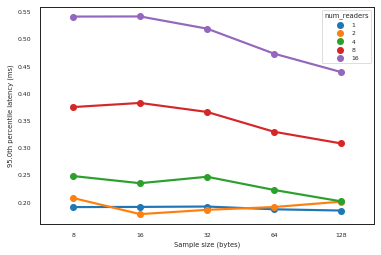

In [109]:

# Event latency:
nth_percentile = 95
df = agg_results.query(f'tag == "event" and percentile == {nth_percentile} and dt_ms == 1.0 and num_readers <= 16')
fig, ax = plt.subplots()
sns.pointplot(
    data=df,
    y='latency_ms_percentile',
    x='sample_size_bytes',
    hue='num_readers',
    ax=ax,
)
ax.set_ylabel(f'{nth_percentile:.1f}th percentile latency (ms)')
ax.set_xlabel('Sample size (bytes)')

fig.savefig('/tmp/event_latencies.pdf')



,dt,batch_size,n_samples,sample_size_bytes,num_readers,tag,percentile,latency_ms_percentile,dt_ms,mb_s,latency_ms_percentile_log,dt_ms_log,batch_size_log
213,0.001,32,640000,768,1,ephys,95.0,1.186217,1.0,23.4375,0.074164,0.00000,5.0
220,0.002,64,640000,768,1,ephys,95.0,1.690832,2.0,23.4375,0.228100,0.30103,6.0
227,0.004,128,640000,768,1,ephys,95.0,2.918537,4.0,23.4375,0.465165,0.60206,7.0
234,0.008,256,640000,768,1,ephys,95.0,5.105952,8.0,23.4375,0.708077,0.90309,8.0
262,0.016,512,640000,768,1,ephys,95.0,8.046792,16.0,23.4375,0.905623,1.20412,9.0
269,0.032,1024,640000,768,1,ephys,95.0,14.464529,32.0,23.4375,1.160304,1.50515,10.0


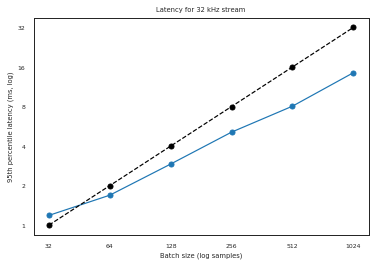

In [158]:


df = (
    agg_results
        .query('tag == "ephys"')
        .assign(mb_s=lambda x: x['batch_size'] * 1 / x['dt'] * x['sample_size_bytes'] / 1024 / 1024)
        .query('percentile == 95.0')
        .assign(latency_ms_percentile_log=lambda x: np.log10(x['latency_ms_percentile']))
        .assign(dt_ms_log=lambda x: np.log10(x['dt_ms']))
        .assign(batch_size_log=lambda x: np.log2(x['batch_size']))
)
s = set(df['mb_s'])
assert len(s) == 1
throughput = list(s)[0]


df
#
fig, ax = plt.subplots()
ax.plot(df['batch_size_log'], df['latency_ms_percentile_log'], markersize=5, marker='o')
ax.plot(df['batch_size_log'], df['dt_ms_log'], markersize=5, ls='--', color='black', marker='o')

bs = np.sort(df['batch_size_log'].unique())
ax.set_xticks(bs)
ax.set_xticklabels(np.round(np.power(2, bs)).astype(np.int64))

ms = np.sort(df['dt_ms_log'].unique())
ax.set_yticks(ms)
ax.set_yticklabels(np.round(np.power(10, ms)).astype(np.int64))

ax.set_xlabel('Batch size (log samples)')
ax.set_ylabel('95th percentile latency (ms, log)')


ax.set_title(f'Latency for 32 kHz stream')

fig.savefig('/tmp/throughputs.pdf')
df


In [104]:


df = (
    agg_results
        .query('tag == "imaging"')
        .assign(mb_s=lambda x: x['batch_size'] * 1 / x['dt'] * x['sample_size_bytes'] / 1024 / 1024)
        .query('percentile == 99.0')
)
df


,dt,batch_size,n_samples,sample_size_bytes,num_readers,tag,percentile,latency_ms_percentile,dt_ms,mb_s
242,0.008333,1,2400,76800,1,imaging,99.0,1.972767,8.333333,8.789062
249,0.008333,1,2400,307200,1,imaging,99.0,6.702541,8.333333,35.156250
256,0.008333,1,2400,1228800,1,imaging,99.0,263.886052,8.333333,140.625000


In [192]:

# Then test maximum read and write throughputs separately:
raw_throughput_results_fn = 'raw_throughput_results.parquet'

if os.path.exists(raw_throughput_results_fn) and False:
    raw_throughputs = pd.read_parquet(raw_throughput_results_fn)
else:
    raw_throughputs = []
    for d in [
        dict(
            # No latency
            dt=0.000,
            batch_size=batch_size,
            n_samples=128000,
            sample_size_bytes=256,
            num_readers=1,
        ) for batch_size in (1, 2, 4, 8, 16, 32, 64, 128)
    ]:
        df = performance.test_performance(
            redis_hostname=redis_hostname,
            redis_password=redis_password,
            redis_port=6379,
            read_simultaneously=False,
            **d,
        )
        raw_throughputs.append(df)

    raw_throughputs = pd.concat(raw_throughputs)
    raw_throughputs.to_parquet(raw_throughput_results_fn)

raw_throughputs


I20220627 09:57:20.718657 3539691 redis.cpp:47] AUTH response: OK
I20220627 09:57:20.729703 3539691 writer.cpp:231] Relative time (local - server) = -1226 us
I20220627 09:57:20.730033 3539691 writer.cpp:90] Stream metadata:
I20220627 09:57:20.730041 3539691 writer.cpp:92] => user_metadata: null
I20220627 09:57:20.730044 3539691 writer.cpp:92] => local_minus_server_clock_us: -1226
I20220627 09:57:20.730049 3539691 writer.cpp:92] => schema: {"field_definitions":[{"name":"data","size":256,"type":"FIXED_WIDTH_BYTES"}]}
I20220627 09:57:20.730053 3539691 writer.cpp:92] => initialized_at_us: 1656349040730942
I20220627 09:57:20.730057 3539691 writer.cpp:92] => first_stream_key: 1cbe005c-4b4d-4154-b963-ed67d6f14505-0


Writing with batch size 1, # batches 128000 [total 128000]
Sleeping, waiting for everything to catch up...
Executing!


I20220627 09:57:36.039413 3539691 writer.cpp:246] Adding eof entry for stream 1cbe005c-4b4d-4154-b963-ed67d6f14505, idx 0 at samples 128100
I20220627 09:57:37.435283 3559241 redis.cpp:47] AUTH response: OK
I20220627 09:57:51.646293 3559241 reader.cpp:199] EOF received! Ending stream with 0 elements at sample 128099


1
1


I20220627 09:57:51.852260 3539691 redis.cpp:47] AUTH response: OK
I20220627 09:57:51.864061 3539691 writer.cpp:231] Relative time (local - server) = -1238 us
I20220627 09:57:51.864419 3539691 writer.cpp:90] Stream metadata:
I20220627 09:57:51.864426 3539691 writer.cpp:92] => user_metadata: null
I20220627 09:57:51.864431 3539691 writer.cpp:92] => local_minus_server_clock_us: -1238
I20220627 09:57:51.864435 3539691 writer.cpp:92] => schema: {"field_definitions":[{"name":"data","size":256,"type":"FIXED_WIDTH_BYTES"}]}
I20220627 09:57:51.864439 3539691 writer.cpp:92] => initialized_at_us: 1656349071865313
I20220627 09:57:51.864444 3539691 writer.cpp:92] => first_stream_key: 1eeb9ec3-3e17-46f3-a817-783a4c2477e5-0


Writing with batch size 2, # batches 64000 [total 128000]
Sleeping, waiting for everything to catch up...
Executing!


I20220627 09:58:00.260567 3539691 writer.cpp:246] Adding eof entry for stream 1eeb9ec3-3e17-46f3-a817-783a4c2477e5, idx 0 at samples 128200
I20220627 09:58:01.664404 3559939 redis.cpp:47] AUTH response: OK
I20220627 09:58:09.029016 3559939 reader.cpp:199] EOF received! Ending stream with 0 elements at sample 128199
I20220627 09:58:09.187412 3539691 redis.cpp:47] AUTH response: OK
I20220627 09:58:09.198593 3539691 writer.cpp:231] Relative time (local - server) = -1229 us
I20220627 09:58:09.198941 3539691 writer.cpp:90] Stream metadata:
I20220627 09:58:09.198948 3539691 writer.cpp:92] => user_metadata: null
I20220627 09:58:09.198953 3539691 writer.cpp:92] => local_minus_server_clock_us: -1229
I20220627 09:58:09.198957 3539691 writer.cpp:92] => schema: {"field_definitions":[{"name":"data","size":256,"type":"FIXED_WIDTH_BYTES"}]}
I20220627 09:58:09.198961 3539691 writer.cpp:92] => initialized_at_us: 1656349089199834
I20220627 09:58:09.198966 3539691 writer.cpp:92] => first_stream_key: 97b8

1
1
Writing with batch size 4, # batches 32000 [total 128000]
Sleeping, waiting for everything to catch up...
Executing!


I20220627 09:58:14.253618 3539691 writer.cpp:246] Adding eof entry for stream 97b81050-46f9-4db8-994d-9236115fdd62, idx 0 at samples 128400
I20220627 09:58:15.645416 3559941 redis.cpp:47] AUTH response: OK
I20220627 09:58:19.587806 3559941 reader.cpp:199] EOF received! Ending stream with 0 elements at sample 128399
I20220627 09:58:19.727938 3539691 redis.cpp:47] AUTH response: OK
I20220627 09:58:19.739130 3539691 writer.cpp:231] Relative time (local - server) = -1213 us
I20220627 09:58:19.739447 3539691 writer.cpp:90] Stream metadata:
I20220627 09:58:19.739455 3539691 writer.cpp:92] => user_metadata: null
I20220627 09:58:19.739460 3539691 writer.cpp:92] => local_minus_server_clock_us: -1213
I20220627 09:58:19.739464 3539691 writer.cpp:92] => schema: {"field_definitions":[{"name":"data","size":256,"type":"FIXED_WIDTH_BYTES"}]}
I20220627 09:58:19.739468 3539691 writer.cpp:92] => initialized_at_us: 1656349099740356
I20220627 09:58:19.739472 3539691 writer.cpp:92] => first_stream_key: 3ce4

1
1
Writing with batch size 8, # batches 16000 [total 128000]
Sleeping, waiting for everything to catch up...
Executing!


I20220627 09:58:23.958765 3539691 writer.cpp:246] Adding eof entry for stream 3ce4928e-1796-4188-b4f9-54922327eb68, idx 0 at samples 128800
I20220627 09:58:25.351549 3559943 redis.cpp:47] AUTH response: OK
I20220627 09:58:30.518230 3559943 reader.cpp:199] EOF received! Ending stream with 0 elements at sample 128799
I20220627 09:58:30.660102 3539691 redis.cpp:47] AUTH response: OK
I20220627 09:58:30.671033 3539691 writer.cpp:231] Relative time (local - server) = -1204 us
I20220627 09:58:30.671350 3539691 writer.cpp:90] Stream metadata:
I20220627 09:58:30.671356 3539691 writer.cpp:92] => user_metadata: null
I20220627 09:58:30.671361 3539691 writer.cpp:92] => local_minus_server_clock_us: -1204
I20220627 09:58:30.671365 3539691 writer.cpp:92] => schema: {"field_definitions":[{"name":"data","size":256,"type":"FIXED_WIDTH_BYTES"}]}
I20220627 09:58:30.671370 3539691 writer.cpp:92] => initialized_at_us: 1656349110672248
I20220627 09:58:30.671373 3539691 writer.cpp:92] => first_stream_key: 9775

1
1
Writing with batch size 16, # batches 8000 [total 128000]
Sleeping, waiting for everything to catch up...
Executing!


I20220627 09:58:33.654913 3539691 writer.cpp:246] Adding eof entry for stream 97755ef4-38c0-4da5-b4a6-b0b50e185e8d, idx 0 at samples 129600
I20220627 09:58:35.049063 3559945 redis.cpp:47] AUTH response: OK
I20220627 09:58:37.815848 3559945 reader.cpp:199] EOF received! Ending stream with 0 elements at sample 129599
I20220627 09:58:37.941108 3539691 redis.cpp:47] AUTH response: OK
I20220627 09:58:37.952111 3539691 writer.cpp:231] Relative time (local - server) = -1193 us
I20220627 09:58:37.952430 3539691 writer.cpp:90] Stream metadata:
I20220627 09:58:37.952437 3539691 writer.cpp:92] => user_metadata: null
I20220627 09:58:37.952441 3539691 writer.cpp:92] => local_minus_server_clock_us: -1193
I20220627 09:58:37.952446 3539691 writer.cpp:92] => schema: {"field_definitions":[{"name":"data","size":256,"type":"FIXED_WIDTH_BYTES"}]}
I20220627 09:58:37.952450 3539691 writer.cpp:92] => initialized_at_us: 1656349117953315
I20220627 09:58:37.952455 3539691 writer.cpp:92] => first_stream_key: 45c5

1
1
Writing with batch size 32, # batches 4000 [total 128000]
Sleeping, waiting for everything to catch up...
Executing!


I20220627 09:58:40.373308 3539691 writer.cpp:246] Adding eof entry for stream 45c5a865-1dea-4d17-abf7-340fbe950db2, idx 0 at samples 131200
I20220627 09:58:41.767859 3559947 redis.cpp:47] AUTH response: OK
I20220627 09:58:43.504717 3559947 reader.cpp:199] EOF received! Ending stream with 0 elements at sample 131199
I20220627 09:58:43.638361 3539691 redis.cpp:47] AUTH response: OK
I20220627 09:58:43.649366 3539691 writer.cpp:231] Relative time (local - server) = -1187 us
I20220627 09:58:43.649677 3539691 writer.cpp:90] Stream metadata:
I20220627 09:58:43.649684 3539691 writer.cpp:92] => user_metadata: null
I20220627 09:58:43.649689 3539691 writer.cpp:92] => local_minus_server_clock_us: -1187
I20220627 09:58:43.649693 3539691 writer.cpp:92] => schema: {"field_definitions":[{"name":"data","size":256,"type":"FIXED_WIDTH_BYTES"}]}
I20220627 09:58:43.649698 3539691 writer.cpp:92] => initialized_at_us: 1656349123650567
I20220627 09:58:43.649701 3539691 writer.cpp:92] => first_stream_key: 1e69

1
1
Writing with batch size 64, # batches 2000 [total 128000]
Sleeping, waiting for everything to catch up...
Executing!


I20220627 09:58:45.856046 3539691 writer.cpp:246] Adding eof entry for stream 1e694b67-5982-4ec8-b691-2128fa6a8907, idx 0 at samples 134400
I20220627 09:58:47.250818 3559949 redis.cpp:47] AUTH response: OK
I20220627 09:58:48.516933 3559949 reader.cpp:199] EOF received! Ending stream with 0 elements at sample 134399
I20220627 09:58:48.647960 3539691 redis.cpp:47] AUTH response: OK
I20220627 09:58:48.659029 3539691 writer.cpp:231] Relative time (local - server) = -1184 us
I20220627 09:58:48.659355 3539691 writer.cpp:90] Stream metadata:
I20220627 09:58:48.659363 3539691 writer.cpp:92] => user_metadata: null
I20220627 09:58:48.659368 3539691 writer.cpp:92] => local_minus_server_clock_us: -1184
I20220627 09:58:48.659371 3539691 writer.cpp:92] => schema: {"field_definitions":[{"name":"data","size":256,"type":"FIXED_WIDTH_BYTES"}]}
I20220627 09:58:48.659375 3539691 writer.cpp:92] => initialized_at_us: 1656349128660223
I20220627 09:58:48.659379 3539691 writer.cpp:92] => first_stream_key: 9db8

1
1
Writing with batch size 128, # batches 1000 [total 128000]
Sleeping, waiting for everything to catch up...
Executing!


I20220627 09:58:50.728037 3539691 writer.cpp:246] Adding eof entry for stream 9db873b1-dc35-4445-a345-9328584c6959, idx 0 at samples 140800
I20220627 09:58:52.130364 3559951 redis.cpp:47] AUTH response: OK


1
1


I20220627 09:58:53.589016 3559951 reader.cpp:199] EOF received! Ending stream with 0 elements at sample 140799


,sample_written_at,sample_index,sample_received_at,latency,latency_ms,dt,batch_size,n_samples,sample_size_bytes,num_readers
0,1.270824e+07,100,1.270826e+07,15.588251,15588.250993,0.0,1,128000,256,1
1,1.270824e+07,101,1.270826e+07,15.585353,15585.352639,0.0,1,128000,256,1
2,1.270824e+07,102,1.270826e+07,15.585187,15585.186945,0.0,1,128000,256,1
3,1.270824e+07,103,1.270826e+07,15.585074,15585.073784,0.0,1,128000,256,1
4,1.270824e+07,104,1.270826e+07,15.584956,15584.956102,0.0,1,128000,256,1
...,...,...,...,...,...,...,...,...,...,...
995,1.270833e+07,1095,1.270833e+07,2.860182,2860.181652,0.0,128,128000,256,1
996,1.270833e+07,1096,1.270833e+07,2.860431,2860.430775,0.0,128,128000,256,1
997,1.270833e+07,1097,1.270833e+07,2.860832,2860.832075,0.0,128,128000,256,1
998,1.270833e+07,1098,1.270833e+07,2.861003,2861.003233,0.0,128,128000,256,1


In [203]:

df['total_bytes'] / 1024 / 1024


0    31.25
1    31.25
2    31.25
3    31.25
4    31.25
5    31.25
6    31.25
7    31.25
Name: total_bytes, dtype: float64

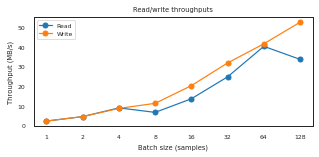

In [209]:

key_cols = ['dt', 'batch_size', 'n_samples', 'sample_size_bytes', 'num_readers']
df = (
    raw_throughputs
        .groupby(key_cols)[['sample_written_at', 'sample_received_at']]
        .agg([np.max, np.min])
        .reset_index()
        .assign(total_bytes=lambda x: x['sample_size_bytes'] * x['n_samples'])
        .assign(write_elapsed_secs=lambda x: x['sample_written_at', 'amax'] - x['sample_written_at', 'amin'])
        .assign(read_elapsed_secs=lambda x: x['sample_received_at', 'amax'] - x['sample_received_at', 'amin'])
        # .drop(columns=[[a, b] for a in ('sample_received_at', 'sample_written_at') for b in ('amax', 'amin')])
        .assign(write_throughput_mb_s=lambda x: x['total_bytes'] / 1024 / 1024 / x['write_elapsed_secs'])
        .assign(read_throughput_mb_s=lambda x: x['total_bytes'] / 1024 / 1024 / x['read_elapsed_secs'])
        .assign(batch_size_log=lambda x: np.log2(x['batch_size']))
)

fig, ax = plt.subplots(figsize=(5, 2))
ax.plot(df['batch_size_log'], df['read_throughput_mb_s'], label='Read', marker='o', markersize=5)
ax.plot(df['batch_size_log'], df['write_throughput_mb_s'], label='Write', marker='o', markersize=5)
ax.legend()

ax.set_xticks(df['batch_size_log'])
ax.set_xticklabels(np.round(np.power(2, df['batch_size_log'])).astype(np.int64))
ax.set_ylabel('Throughput (MB/s)')
ax.set_xlabel('Batch size (samples)')
ax.set_title('Read/write throughputs')

fig.savefig('/tmp/raw_throughputs.pdf')
